## 实验：实现二层神经网络误差反向传播法

### 实验概要

#### 神经网络学习的基本步骤

利用随机梯度下降法，求梯度并更新权重和偏置参数，整个过程是个循环过程。

1. 从训练数据中随机选择一部分数据
2. 构建网络，利用前向传播，求出输出值。然后利用输出值与目标值得到损失函数，利用损失函数，利用反向传播方法，求各参数的梯度。
3. 将权重参数沿梯度方向进行微小更新
4. 重复以上 1、2、3 步骤

#### 神经网络学习的反向传播法的实现

为定义和保存以上神经网络架构，需要先定义几个实例变量：
- 保存权重参数的字典型变量 params。
- 保存各层的信息的顺序字典 layers，这里的顺序是插入数据的先后顺序。
- 神经网络的最后一层 lastlayer

除了以上三个实例变量，还需要定义一些方法
- 构造函数，以初始化变量和权重等
- 预测方法，根据神经网络各层的前向传播得到最后的输出值
- 损失函数，根据输出值与目标值，得到交叉熵作为衡量两个分布的距离。
- 评估指标，这里使用精度来衡量模型性能
- 最后就是计算梯度，这里使用反向传播方法的得到，具体是利用导数的链式法则，从后往前，获取各层的梯度作为前层梯度往前传递（往输入端）

当然，这里需要先定义好各层类，各类中各层的权重参数、包括前向传播结果，反向传播的梯度等。

### 实验目标

在本实验中，我们将实现二层神经网络误差反向传播法。

#### 二层神经网络 vs. 三层神经网络

对于初学者，可能会对单层神经网络、二层神经网络、三层神经网络这些说法有点模糊：

![](./img/1_12.png)

- **左边：** 是一个 2 层神经网络，隐层由 4 个神经元（也可称为单元（unit））组成，输出层由 2 个神经元组成，输入层是 3 个神经元。
- **右边：** 是一个 3 层神经网络，两个含 4 个神经元的隐层。注意：层与层之间的神经元是全连接的，但是层内的神经元不连接。

#### 命名规则

当我们说 N 层神经网络的时候，我们没有把输入层算入。因此，单层的神经网络就是没有隐层的（输入直接映射到输出）。因此，有的研究人员会认为 **逻辑回归** 或者 **SVM** 只是单层神经网络的一个特例。研究者们也会使用 **人工神经网络**（Artificial Neural Networks 缩写: **ANN**）或者 **多层感知器**（Multi-Layer Perceptrons 缩写: **MLP**）来指代神经网络。同样，很多研究人员并不喜欢神经网络算法和人类大脑之间的类比，他们更倾向于用单元（**unit**）而不是神经元（**neuron**）作为术语。

### 1. 定义激活函数

In [1]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
 
    #防止出现溢出情况
    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))
 
class Sigmoid:
    def __init__(self):
        self.out=None
        
    def forward(self,x):
        self.out=1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self,dout):
        dx=dout*(1.0 -self.out) * self.out
        return dx
    
class Relu:
    def __init__(self):
        self.mask = None
 
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
 
        return out
 
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
 
        return dx

### 2. 定义 Affine 层

In [2]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None
 
    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
 
        out = np.dot(self.x, self.W) + self.b
 
        return out
 
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        # 还原输入数据的形状（对应张量）
        dx = dx.reshape(*self.original_x_shape)  
        return dx

### 3. 定义 SoftmaxWithLoss 层

In [3]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        # softmax的输出
        self.y = None 
        # 监督数据
        self.t = None 
 
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
 
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        # 监督数据是one-hot-vector的情况
        if self.t.size == self.y.size: 
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### 4. 定义损失函数

In [4]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 如果t为one-hot格式，把它转换为数字格式
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-8)) / batch_size

### 5. 定义神经网络类

实例变量如下：

- **params：** 保存神经网络的参数的字典型变量。
   - `params['W1']` 是第 1 层的权重， `params['b1']` 是第 1 层的偏置
   - `params['W2']` 是第 2 层的权重， `params['b2']` 是第 2 层的偏置

- **layers：** 保存神经网络的层的有序字典型变量。
   - 以 `layers['Affine1']`、 `layers['ReLu1']`、 `layers['Affine2']` 的形式，
   - 通过有序字典保存各个层

- **lastLayer：** 神经网络的最后一层。本实验中为 SoftmaxWithLoss 层

`TwoLayerNet` 类使用了层。通过使用层，获得识别结果的处理（`predict()`）和计算梯度的处理（`gradient()`）只需通过层之间的传递就能完成。


通过将神经网络的组成元素以层的方式实现，可以轻松地构建神经网络。这个用层进行模块化的实现具有很大优点。因为想另外构建一个神经网络（比如 5 层、 10 层、 20 层……的大的神经网络）时，只需像组装积木那样添加必要的层就可以了。之后，通过各个层内部实现的正向传播和反向传播，就可以正确计算进行识别处理或学习所需的梯度。下面是代码实现。

In [5]:
import numpy as np
from collections import OrderedDict
 
class TwoLayerNet:
 
    # 进行初始化。参数从头开始依次是输入层的神经元数、隐藏层的神经元数、
    # 输出层的神经元数、初始化权重时的高斯分布的规模
    def __init__(self, input_size, hidden_size,output_size, weight_init_std = 0.01):
        
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
 
        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        
        # self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
 
        self.lastLayer = SoftmaxWithLoss()
    
    # 进行识别（推理）。参数x是图像数据
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # 计算损失函数的值。参数x是图像数据、t是正确解标签
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    # 计算识别精度
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        
        # print("预测值",y[0],y.shape)        
        if t.ndim != 1: 
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # 通过数值微分计算关于权重参数的梯度
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # 通过误差反向传播法计算关于权重参数的梯度   
    def gradient(self, x, t):
        # 前向
        self.loss(x, t)
 
        # 后向
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
 
        # 用一个字典记录各参数（权重和偏置）的梯度
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
 
        return grads

其中，代码中的 ——

```python
# 生成层
self.layers = OrderedDict()
self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
```
`OrderedDict` 是有序字典，**有序** 是指它可以记住向字典里添加元素的顺序。因此，神经网络的正向传播只需按照添加元素的顺序调用各层的 `forward()`方法就可以完成处理，而反向传播只需要按照相反的顺序调用各层即可。因为 Afne 层和 ReLU 层的内部会正确处理正向传播和反向传播，所以这里要做的事情仅仅是以正确的顺序连接各层，再按顺序（或者逆序）调用各层。

### 6. 使用误差反向传播法训练模型

#### 6.1 导入库

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# 导入pickle执行序列化
import pickle  

#### 6.2 读入数据

使用 data 中内置的 mnist

In [7]:
import os
base_path = os.environ.get("BATH_PATH",'./data/')
data_path = os.path.join(base_path + "lab12/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)
file_path = data_path + "mnist.pkl"

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """读入MNIST数据集
    
    Parameters
    ----------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label : 
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组
    
    Returns
    -------
    (训练图像, 训练标签), (测试图像, 测试标签)
    """
    with open(file_path, 'rb') as f:
        
        # 通过利用对象 f，使用 pickle 加载存储在本地的数据
        dataset = pickle.load(f)        
    
    # normalize=True，执行标准化
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            
            # 由于图像的像素值是0-255，直接除以255，将像素值标准化为[0-1]区间内
            dataset[key] /= 255.0      
    
    # one_hot_label=False，不执行one-hot表示，此操作忽略
    if one_hot_label:
        
        # 引用 change_one_hot_label() 函数执行one-hot表示
        dataset['train_label'] = _change_one_hot_label(dataset['train_label']) 
        
        # 引用 change_one_hot_label() 函数执行one-hot表示
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])   
    
    # flatten=True，此操作忽略
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], 
                                                            dataset['test_label']) 

(x_train, t_train), (x_test, t_test) = load_mnist()

#### 6.3 参数设置

In [8]:
# 适当设定循环的次数，可以增加迭代次数提升准确率，
# 同时可以看到更平滑上升的学习曲线，然而训练时间同时也会被拉长
iters_num = 2000  
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

#### 6.4 模型训练

> **训练预计需时 30 分钟，请耐心等待。**

In [9]:
# 记录模型训练时间
import time 
# 记录训练开始时间
start_sum = time.time() 

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 通过误差反向传播法求梯度
    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
         
        # 更新
        if i%100==0:
            learning_rate*=0.9

       # 更新参数
        print("学习速率：" + str(learning_rate))
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("训练集准确率, 测试集准确率 | " + 
              str(train_acc) + ", " + str(test_acc))
        
# 记录训练结束时间
end_sum = time.time() 
print('训练总耗时：',end_sum - start_sum, '秒')

学习速率：0.09000000000000001
训练集准确率, 测试集准确率 | 0.14038333333333333, 0.1334
学习速率：0.08100000000000002
训练集准确率, 测试集准确率 | 0.9017833333333334, 0.905
学习速率：0.07290000000000002
训练集准确率, 测试集准确率 | 0.9155, 0.9215
学习速率：0.06561000000000002
训练集准确率, 测试集准确率 | 0.9283666666666667, 0.9283
训练总耗时： 10.856628656387329 秒


#### 6.5 结果可视化

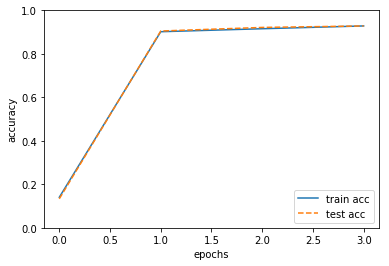

In [10]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))

plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 实验小结

在本实验中，你实现了二层神经网络误差反向传播法。了解了神经网络中的误差反向传播法，并以层为单位实现了神经网络中的处理。同时，在 ReLU 层、Softmax-with-Loss 层、 Afne 层、Softmax 层中实现了 forward 和 backward 方法。通过将数据正向和反向地传播，可以高效地计算权重参数的梯度。通过使用层进行模块化，神经网络中可以自由地组装层，轻松构建出自己喜欢的网络。